## Multiclass SVM

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function

In [3]:
# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
cifar10_dir = '/mnt/56EA7396EA7370DB/source/u_stanford/cs231_lightaime/assignment1/cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


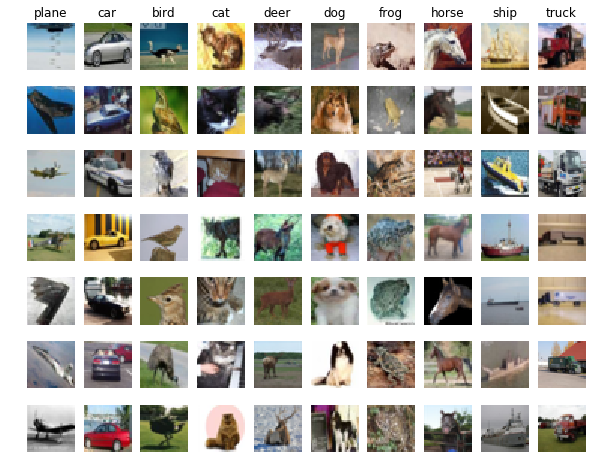

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
#     print(idxs)
#     print(len(idxs))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i* num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val and test sets. 
# Create a small development set as s subset of the training data
# We can use this for development so our code runs faster
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

In [7]:
# Our validation set will be num_validation points from the original
# training set
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

In [8]:
X_val

array([[[[ 171.,  187.,  214.],
         [ 169.,  187.,  214.],
         [ 168.,  187.,  214.],
         ..., 
         [ 183.,  194.,  212.],
         [ 180.,  190.,  209.],
         [ 181.,  192.,  210.]],

        [[ 170.,  184.,  211.],
         [ 168.,  184.,  210.],
         [ 167.,  185.,  210.],
         ..., 
         [ 186.,  190.,  210.],
         [ 182.,  189.,  208.],
         [ 180.,  190.,  209.]],

        [[ 171.,  185.,  211.],
         [ 168.,  184.,  209.],
         [ 168.,  185.,  210.],
         ..., 
         [ 182.,  189.,  209.],
         [ 180.,  188.,  207.],
         [ 179.,  190.,  208.]],

        ..., 
        [[ 113.,  133.,  149.],
         [ 115.,  135.,  151.],
         [ 117.,  137.,  153.],
         ..., 
         [ 119.,  142.,  155.],
         [ 120.,  142.,  156.],
         [ 119.,  141.,  155.]],

        [[ 111.,  131.,  147.],
         [ 112.,  131.,  147.],
         [ 113.,  132.,  148.],
         ..., 
         [ 116.,  138.,  152.],
       

In [9]:
# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

In [10]:
# Development set
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [11]:
# Test set
mask = range(num_test)
print(mask)
X_test = X_test[mask]
y_test = y_test[mask]

range(0, 1000)


In [12]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [13]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


[ 130.64189796  135.98173469  132.47391837 ...,  126.64218367  125.86195918
  114.39957143]


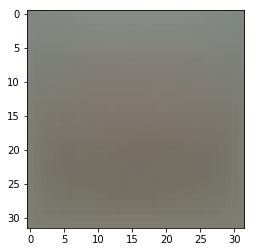

In [14]:
# Preprocessing: subtract the mean image
# 1: compute the image mean based on the training data
mean_image = np.mean(X_train, axis = 0)
print(mean_image)
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))
plt.show()

In [15]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [16]:
# 3: append the bias dimension of ones so that our SVM
# Only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

In [17]:
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM classifier

In [18]:
# Your code will all be written inside cs231n/classifiers/linear_svm.py

In [19]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

In [20]:
# Generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' %(loss, ))

loss: 9.149635


In [21]:
# Compute the loss and its gradient at W
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
print('loss: %f' %(loss, ))
#

loss: 9.149635


In [22]:
# Numerically compute the gradient along several randomly chosen dimensions, and compare them with your analyticaly computed gradient. The numbers should match 
# almost exactly along all dimentions
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 6.563502 analytic: 6.563502, relative error: 1.837142e-11
numerical: -6.771800 analytic: -6.771800, relative error: 8.050764e-12
numerical: -18.379512 analytic: -18.379512, relative error: 7.309738e-12
numerical: 34.233594 analytic: 34.233594, relative error: 9.576687e-13
numerical: -15.053720 analytic: -15.053720, relative error: 1.342924e-11
numerical: 13.271604 analytic: 13.271604, relative error: 2.537052e-11
numerical: -1.457341 analytic: -1.457341, relative error: 5.496582e-11
numerical: -10.888236 analytic: -10.888236, relative error: 2.551149e-11
numerical: 33.662930 analytic: 33.662930, relative error: 8.843334e-12
numerical: -21.840514 analytic: -21.840514, relative error: 1.126455e-11


In [23]:
# Do the gradient check once again with regularization turned on 
# your didn't forget the regularization gradient did you
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W,grad)

numerical: 40.556191 analytic: 40.556191, relative error: 3.357875e-12
numerical: -0.301918 analytic: -0.301918, relative error: 6.490633e-10
numerical: -20.623330 analytic: -20.623330, relative error: 4.463948e-12
numerical: 2.961314 analytic: 2.961314, relative error: 1.157049e-10
numerical: 14.926598 analytic: 14.926598, relative error: 3.384118e-12
numerical: -17.279967 analytic: -17.279967, relative error: 1.766615e-11
numerical: -38.322546 analytic: -38.322546, relative error: 2.445017e-12
numerical: -15.152764 analytic: -15.152764, relative error: 1.392627e-11
numerical: 21.499352 analytic: 21.499352, relative error: 1.824332e-13
numerical: 41.255167 analytic: 41.255167, relative error: 3.380554e-12


In [24]:
# Next implement the function svm_loss_vectorized; for now only compute the loss
# We will implement the gradient in a moment
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

Naive loss: 9.149635e+00 computed in 0.255835s


In [25]:
from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc-tic))

Vectorized loss: 9.149635e+00 computed in 0.014375s


In [26]:
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

difference: 0.000000


## Stochastic Gradient Descent

In [27]:
# We now have vectorized and effcient expressions for the loss, the gradient and our gradient matches the numerical gradient. we are therefore realy to do SGD to minimize the loss

In [28]:
x = np.array([1, 2, 3, 4, 5, 7])
y = np.arange(10)
print(y)
np.random.choice(x, 2)

[0 1 2 3 4 5 6 7 8 9]


array([7, 5])

In [29]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below
from cs231n.classifiers import LinearSVM

In [30]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print("That took %fs" % (toc-tic))

iteration 0 / 1500: loss 793.795364
iteration 100 / 1500: loss 289.828201
iteration 200 / 1500: loss 109.038737
iteration 300 / 1500: loss 42.982177
iteration 400 / 1500: loss 19.131725
iteration 500 / 1500: loss 10.395241
iteration 600 / 1500: loss 7.173454
iteration 700 / 1500: loss 5.955354
iteration 800 / 1500: loss 5.326459
iteration 900 / 1500: loss 5.539645
iteration 1000 / 1500: loss 5.156230
iteration 1100 / 1500: loss 5.209465
iteration 1200 / 1500: loss 4.977517
iteration 1300 / 1500: loss 5.594322
iteration 1400 / 1500: loss 5.033742
That took 8.939933s


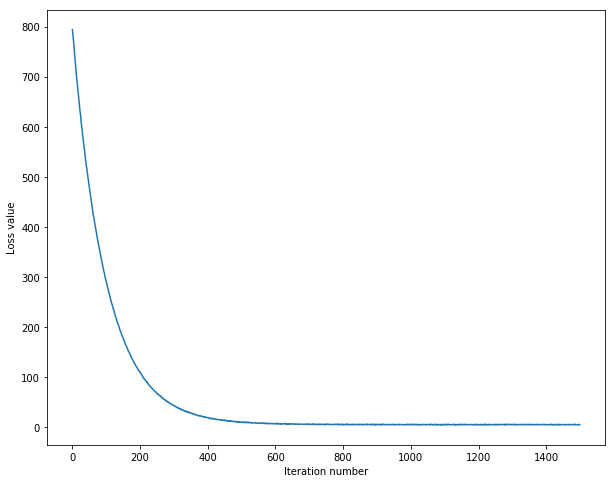

In [31]:
# A useful debugging strategy is to plot the loss as a function of iteration number
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [32]:
# Write the LinearSVM.predict function and evaluate the performance on both the training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369449
validation accuracy: 0.376000


In [33]:
# Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [1.5e4, 5e4]

# results is dictionary mapping tuples of the form
# learning rate, regularization strength; if you are carefull you should be able to get a
# a classification accuracy of about 0.4 on the validation set
learning_rates = [1e-7, 5e-5]
regularization_strengths = [1.5e4, 5e4]


In [34]:
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified
results = {}
best_val = -1 # The highest validation accuracy that we have seen so far
best_svm = None # The LinearSVM object that achieved the highest validation rate

In [35]:
"""
Write code that chooses the best hyperparameters by tuning on the validation set
For each combination of hyperparameters train a linear SVM on the training set, computer its accuracy on the training and validation sets and
store these numbers in the results dictionary. In addition, store the best validation accuracy in best_val and LinearSVM object that achieves this accuracy in best_svm"""
"""
"""
range_lr = np.linspace(learning_rates[0], learning_rates[1], 3)
range_reg = np.linspace(regularization_strengths[0], regularization_strengths[1], 3)

In [36]:
range_lr

array([  1.00000000e-07,   2.50500000e-05,   5.00000000e-05])

In [37]:
range_reg

array([ 15000.,  32500.,  50000.])

In [38]:
for cur_lr in range_lr:
    for cur_reg in range_reg:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=cur_lr, reg=cur_reg, num_iters=1500, verbose=False)
        
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        # Fix storing results
        results[(cur_lr, cur_reg)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

/home/damvantai/Dropbox/source/courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment-1/cs231n/classifiers/linear_svm.py:101: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/home/damvantai/Dropbox/source/courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment-1/cs231n/classifiers/linear_svm.py:101: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/home/damvantai/Dropbox/source/courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment-1/cs231n/classifiers/linear_svm.py:93: RuntimeWarning: overflow encountered in subtract
  margin = scores_ - correct_class_scores[..., np.newaxis] + 1
/home/damvantai/Dropbox/source/courses/CS231n Convolutional Neural Networks for Visual Recognition/assignment-1/cs231n/classifiers/linear_svm.py:118: RuntimeWarning: overflow encountered in subtract
  original_margin = scores - correct_class_scores[...,np.newaxis] + 1
/home/

In [52]:
# Print out results

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))

lr 1.000000e-07 reg 1.500000e+04 train accuracy: 0.376449 val accuracy: 0.380000
lr 1.000000e-07 reg 3.250000e+04 train accuracy: 0.359796 val accuracy: 0.365000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.349755 val accuracy: 0.349000
lr 2.505000e-05 reg 1.500000e+04 train accuracy: 0.170878 val accuracy: 0.176000
lr 2.505000e-05 reg 3.250000e+04 train accuracy: 0.162347 val accuracy: 0.156000
lr 2.505000e-05 reg 5.000000e+04 train accuracy: 0.082041 val accuracy: 0.088000
lr 5.000000e-05 reg 1.500000e+04 train accuracy: 0.157694 val accuracy: 0.159000
lr 5.000000e-05 reg 3.250000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000


In [53]:
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: 0.380000


In [54]:
print(type(results))

<class 'dict'>


In [56]:
print(results)

{(2.5049999999999999e-05, 15000.0): (0.17087755102040816, 0.17599999999999999), (9.9999999999999995e-08, 50000.0): (0.34975510204081633, 0.34899999999999998), (5.0000000000000002e-05, 32500.0): (0.10026530612244898, 0.086999999999999994), (9.9999999999999995e-08, 32500.0): (0.35979591836734692, 0.36499999999999999), (5.0000000000000002e-05, 50000.0): (0.10026530612244898, 0.086999999999999994), (2.5049999999999999e-05, 50000.0): (0.082040816326530611, 0.087999999999999995), (9.9999999999999995e-08, 15000.0): (0.37644897959183671, 0.38), (2.5049999999999999e-05, 32500.0): (0.16234693877551021, 0.156), (5.0000000000000002e-05, 15000.0): (0.15769387755102041, 0.159)}


In [55]:
import math

In [57]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

In [58]:
x_scatter

[-4.601192269796735,
 -7.0,
 -4.301029995663981,
 -7.0,
 -4.301029995663981,
 -4.601192269796735,
 -7.0,
 -4.601192269796735,
 -4.301029995663981]

In [59]:
y_scatter

[4.176091259055681,
 4.698970004336019,
 4.511883360978874,
 4.511883360978874,
 4.698970004336019,
 4.698970004336019,
 4.176091259055681,
 4.511883360978874,
 4.176091259055681]

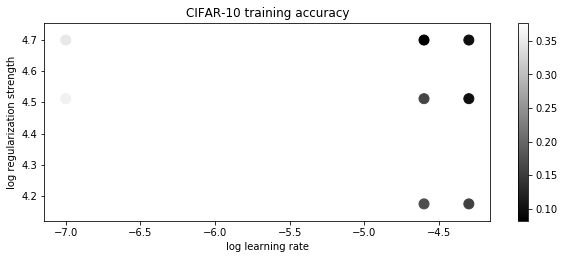

In [66]:
# Plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.show()

In [62]:
for x in results:
    print(results[x][1])

0.176
0.349
0.087
0.365
0.087
0.088
0.38
0.156
0.159


In [67]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print("Linear SVM on raw pixels final test set accuracy: %f" % test_accuracy)

Linear SVM on raw pixels final test set accuracy: 0.375000


In [68]:
# Visualize th learned weights for each class
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

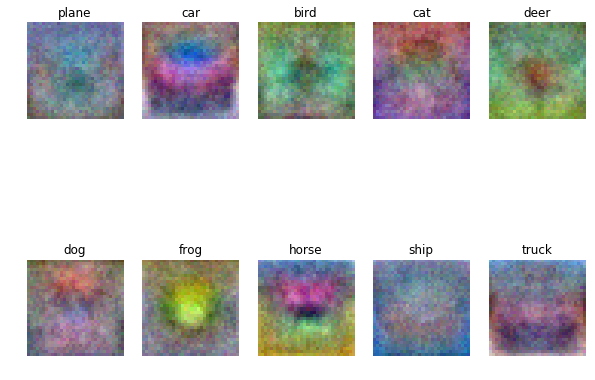

In [70]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [39]:
a = np.array([[1, 2, 3], [4, 5, 6]])

In [40]:
b = np.mean(a, axis=0)

In [41]:
print(b)

[ 2.5  3.5  4.5]


In [42]:
a-b

array([[-1.5, -1.5, -1.5],
       [ 1.5,  1.5,  1.5]])

In [43]:
a = np.hstack([a, np.ones((a.shape[0], 2))])

In [44]:
print(a.shape[0])

2


In [45]:
print(a)

[[ 1.  2.  3.  1.  1.]
 [ 4.  5.  6.  1.  1.]]


In [46]:
for y, cls in enumerate(classes):
    print(y, cls)

0 plane
1 car
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [47]:
len(y_train)

49000

In [48]:
idxs

array([21555, 32192, 16849, 43325,  8999, 12413, 37225])

In [49]:
idxs = np.random.choice(idxs, samples_per_class, replace=False)

In [50]:
idxs

array([21555, 16849, 43325,  8999, 32192, 37225, 12413])

In [51]:
np.linalg.norm(a)

9.7467943448089631